In [8]:
import ipdb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as pylab
import matplotlib as mpl
import cartopy
import cartopy.crs as ccrs
from utils import constants as cnst
from eod import msg
from utils import u_grid, u_interpolate as u_int, u_darrays as uda, u_arrays as ua
from utils import u_statistics as u_stats
import datetime
import matplotlib.colors as mcolors
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from utils import u_plot as uplot
import salem
import numpy.ma as ma
from scipy import stats, ndimage
import warnings
from scipy.ndimage.measurements import label
import shapely.geometry as shpg
import datetime
from scipy.stats import gaussian_kde, linregress
import glob
import pickle as pkl
import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.interpolate import cross_section
import os

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [7]:
cd ..


/home/ck/pythonWorkspace/proj_CEH


In [27]:
epl = '/media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels'
spl = '/media/ck/Elements/SouthAmerica/ERA5/hourly/peru/surface'

regions = {
'equatorial' : [(-5,0)],
'transition' : [(-8,-5),([-7.5,-81],[-3.7,-74])],
'central' : [(-12,-8), ([-11.5,-80],[-4.5,-66])],   # mid:
'southern' : [(-18,-15), ([-17.9,-73.5],[-7,-65])]}
h = 2000

In [28]:
region = 'central'
alls = regions[region]
ccords = alls[1]

In [29]:
start = ccords[0]
end = ccords[1]

In [30]:
topo_full = xr.open_dataset('/media/ck/Elements/SouthAmerica/ERA5/hourly/ERA5_static_hourly_0.25deg_peru.nc')
topo_full = uda.flip_lat(topo_full)

In [31]:
height = xr.open_dataset('/media/ck/Elements/SouthAmerica/ERA5/hourly/topo_ERA5_peru.nc')

In [32]:
dic = pkl.load(open(cnst.network_data+ 'data/HUARAZ/saves/corr_GRIDSAT-15_start_end.p', "rb"))

In [33]:
corr_start = dic['start_3d']
corr_end = dic['end_5d']
corr_start.name = 'r'
corr_end.name = 'r'

In [34]:
dummy = xr.open_dataset(glob.glob('/media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/*.nc')[0]).isel(time=0)
dummy = uda.flip_lat(dummy)

In [35]:
topo = xr.open_dataarray(cnst.TOPO_1MIN).sel(lon=slice(-85,-55), lat=slice(-25,3))
topo_on_g = dummy.salem.lookup_transform(topo)

In [36]:
topo_on_g#.metpy.parse_cf().squeeze()

<xarray.DataArray 'h' (latitude: 77, longitude: 101)>
array([[  0.        ,   0.        ,   0.        , ..., 202.90666667,
         96.41333333, 108.08      ],
       [  0.        ,   0.        ,   0.        , ..., 100.87555556,
         99.12888889, 107.59555556],
       [  0.        ,   0.        ,   0.        , ...,  99.06666667,
         98.36444444, 102.84444444],
       ...,
       [  0.        ,   0.        ,   0.        , ..., 200.60444444,
        198.59555556, 182.92444444],
       [  0.        ,   0.        ,   0.        , ..., 197.88444444,
        204.92888889, 176.31111111],
       [  0.        ,   0.        ,   0.        , ..., 268.37333333,
        239.39555556, 188.41777778]])
Coordinates:
  * longitude  (longitude) float32 -82.0 -81.75 -81.5 ... -57.5 -57.25 -57.0
  * latitude   (latitude) float32 -18.0 -17.75 -17.5 -17.25 ... 0.5 0.75 1.0
Attributes:
    long_name:   Altitude
    units:       m
    pyproj_srs:  +proj=longlat +datum=WGS84 +no_defs

In [37]:
dummy#.metpy.parse_cf().squeeze()

<xarray.Dataset>
Dimensions:    (latitude: 77, level: 17, longitude: 101)
Coordinates:
  * longitude  (longitude) float32 -82.0 -81.75 -81.5 ... -57.5 -57.25 -57.0
  * latitude   (latitude) float32 -18.0 -17.75 -17.5 -17.25 ... 0.5 0.75 1.0
  * level      (level) int32 200 300 400 500 550 600 ... 850 875 900 925 950 975
    time       datetime64[ns] 1979-01-01
Data variables:
    d          (level, latitude, longitude) float32 ...
    z          (level, latitude, longitude) float32 ...
    pv         (level, latitude, longitude) float32 ...
    r          (level, latitude, longitude) float32 ...
    q          (level, latitude, longitude) float32 ...
    t          (level, latitude, longitude) float32 ...
    u          (level, latitude, longitude) float32 ...
    v          (level, latitude, longitude) float32 ...
    w          (level, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-02-28 16:52:04 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

In [38]:
corrs_on_g = dummy.salem.transform(corr_start, interp='nearest').where(topo_on_g>=2000)
corre_on_g = dummy.salem.transform(corr_end, interp='nearest').where(topo_on_g>=2000)

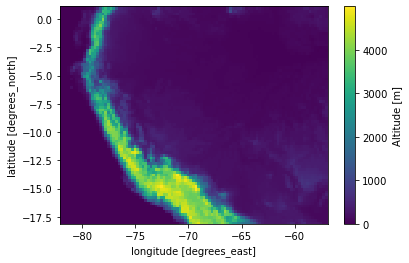

In [39]:
topo_on_g.plot()

In [40]:
tdummy = dummy.metpy.parse_cf().squeeze()

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


In [41]:
cross = cross_section(tdummy, start, end).set_coords(('latitude', 'longitude'))

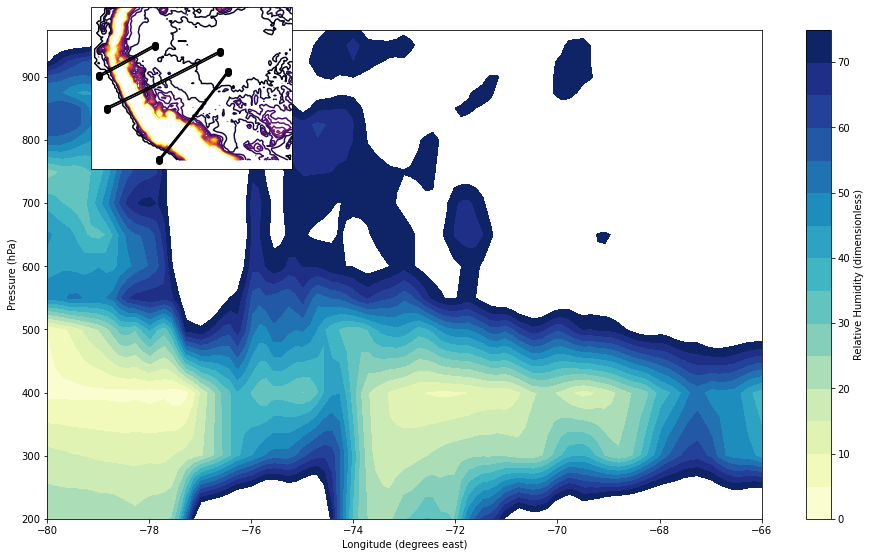

In [42]:
# Define the figure object and primary axes
fig = plt.figure(1, figsize=(16., 9.))
ax = plt.axes()

# Plot RH using contourf
rh_contour = ax.contourf(cross['longitude'], cross['level'], cross['r'],
                         levels=np.arange(0, 80, 5), cmap='YlGnBu')
rh_colorbar = fig.colorbar(rh_contour)

ax.set_ylabel('Pressure (hPa)')
ax.set_xlabel('Longitude (degrees east)')
rh_colorbar.set_label('Relative Humidity (dimensionless)')

# Define the CRS and inset axes
data_crs = tdummy['q'].metpy.cartopy_crs



ax_inset = fig.add_axes([0.125, 0.665, 0.25, 0.25], projection=data_crs)

# Plot geopotential height at 500 hPa using xarray's contour wrapper
ax_inset.contour(tdummy['longitude'], tdummy['latitude'], topo_on_g,
                 levels=np.arange(0, 2000, 100), cmap='inferno')
for reg in ['transition', 'central', 'southern']:
    alls = regions[reg]
    ccords = alls[1]
    start = ccords[0]
    end = ccords[1]
    
    start1 = start.copy()
    start1[0] = start1[0]-0.25
    start2 = start.copy()
    start2[0] = start1[0]+0.25
    
    end1 = end.copy()
    end1[0] = end1[0]-0.25
    end2 = end.copy()
    end2[0] = end1[0]+0.25
    
    # Plot the path of the cross section
    endpoints = data_crs.transform_points(ccrs.Geodetic(),
                                      *np.vstack([start, end]).transpose()[::-1])
    ax_inset.scatter(endpoints[:, 0], endpoints[:, 1], c='k', zorder=2)
    
    
    endpoints = data_crs.transform_points(ccrs.Geodetic(),
                                      *np.vstack([start1, end1]).transpose()[::-1])
    ax_inset.scatter(endpoints[:, 0], endpoints[:, 1], c='k', zorder=2)
    
    endpoints = data_crs.transform_points(ccrs.Geodetic(),
                                      *np.vstack([start2, end2]).transpose()[::-1])
    ax_inset.scatter(endpoints[:, 0], endpoints[:, 1], c='k', zorder=2)
    
    
    cross = cross_section(tdummy, start, end).set_coords(('latitude', 'longitude'))
    ax_inset.plot(cross['longitude'], cross['latitude'], c='k', zorder=2)
    cross = cross_section(tdummy, start1, end1).set_coords(('latitude', 'longitude'))
    ax_inset.plot(cross['longitude'], cross['latitude'], c='k', zorder=2)
    cross = cross_section(tdummy, start2, end2).set_coords(('latitude', 'longitude'))
    ax_inset.plot(cross['longitude'], cross['latitude'], c='k', zorder=2)
    
    
    


plt.show()

In [43]:
# topo_on_g.to_netcdf('/media/ck/Elements/SouthAmerica/ERA5/hourly/topo_ERA5_peru.nc', mode='w', format='NETCDF4')

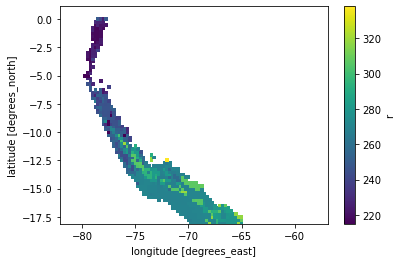

In [44]:
corrs_on_g.plot()

In [45]:
def readERA_perpendicular(r):
    epl = '/media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/*.nc'
    inputs = glob.glob(epl)
    alls = regions[r]
    
    ccords = alls[1]
    start = ccords[0]
    end = ccords[1]
    
    start1[0] = start1[0]-0.25
    start2 = start.copy()
    start2[0] = start1[0]+0.25
    
    end1 = end.copy()
    end1[0] = end1[0]-0.25
    end2 = end.copy()
    end2[0] = end1[0]+0.25

    
    doys = corrs_on_g.sel(latitude=slice(alls[0][0], alls[0][1])).mean()
    doye = corre_on_g.sel(latitude=slice(alls[0][0], alls[0][1])).mean()
    dsdate = pd.Timestamp('2008-01-01')+pd.Timedelta(str(doys.values)+'days')
    dedate = pd.Timestamp('2008-01-01')+pd.Timedelta(str(doye.values)+'days')
    
    alist = []
    

    
    for file in inputs:
        fbasename = os.path.basename(file)
        y = fbasename[5:9]
        m = fbasename[10:12]
        d = fbasename[13:15]
        if (int(y)<1985) | (int(y)>2018):
            continue
        date = pd.Timestamp(y+'-'+m+'-'+d)
        ddoy = date.dayofyear
        print('Doing ', file)
        if (ddoy<doys) & (ddoy>doye):  # check rainy season start end
            print(r, 'start season:', dsdate, 'end season:', dedate)
            print('Outside of rainy season, continue')
            continue

        try:
            u200orig = xr.open_dataset(file).metpy.parse_cf().squeeze()
        except:
            'File read failed, continue'
            continue
        
        u200orig = uda.flip_lat(u200orig)
        u200orig = u200orig.sel(time=(u200orig['time.hour']==15))
            

        cross = cross_section(u200orig, start, end).set_coords(('latitude', 'longitude'))
       # cross = cross + cross_section(u200orig, start1, end1).set_coords(('latitude', 'longitude'))
       # cross = (cross + cross_section(u200orig, start2, end2).set_coords(('latitude', 'longitude')))/3
        
        cross = cross.drop(['pv', 'crs'])
        datetimes = pd.to_datetime(cross.time.values)
        newtimes = []
        for t in datetimes:
            newtimes.append(t.replace(hour=0))
        cross['time'] = ('time', newtimes)
        alist.append(cross)
    ds = xr.concat(alist, dim='time')
    
    comp = dict(zlib=True, complevel=5)
    encoding = {var: comp for var in ds.data_vars} #{var: comp}
    ds.to_netcdf('/media/ck/Elements/SouthAmerica/ERA5/hourly/'+r+'_perpendicular_15UTC_1985-2018_peru_v2.nc', mode='w',
                       encoding=encoding, format='NETCDF4')
    
    

In [26]:
readERA_perpendicular('central')

NameError: name 'start1' is not defined

In [46]:
readERA_perpendicular('southern')

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_07_26_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_03_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_11_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_07_16_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_03_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_01_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_01_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_01_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_01_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_01_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_01_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_01_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_01_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_01_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_01_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_01_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_01_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_01_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_01_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_01_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_01_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_01_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_01_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_01_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_01_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_01_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_01_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_01_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_01_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_01_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_01_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_01_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_01_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_01_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_02_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_02_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_02_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_02_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_02_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_02_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_02_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_02_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_02_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_02_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_02_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_02_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_02_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_02_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_02_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_02_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_02_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_02_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_02_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_02_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_02_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_02_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_02_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_02_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_02_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_02_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_02_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_03_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_03_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_03_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_03_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_03_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_03_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_03_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_03_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_03_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_03_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_03_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_03_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_03_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_03_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_03_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_03_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_03_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_03_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_03_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_03_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_03_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_03_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_03_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_03_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_03_27_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_03_28_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_03_29_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_03_30_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_03_31_pl.nc
southern start season: 200

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longi

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_01_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_02_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_03_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_03_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_04_05_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_04_21_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_05_07_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_05_23_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_06_08_pl.nc
southern start season: 200

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_10_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_10_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_10_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_10_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_10_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_10_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_10_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_10_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_10_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_10_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_10_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_10_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_10_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_10_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_10_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_10_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_10_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_10_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_10_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_10_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_10_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_10_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_10_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_10_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_10_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_11_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_11_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_11_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_11_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_11_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_11_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_11_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_11_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_11_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_11_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_11_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_11_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_11_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_11_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_11_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_11_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_11_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_11_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_11_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_11_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_11_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_11_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_11_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_11_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_11_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_11_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_11_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_11_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_11_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_12_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_12_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_12_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_12_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_12_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_12_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_12_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_12_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_12_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_12_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_12_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_12_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_12_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_12_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_12_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_12_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_12_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_12_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_12_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_12_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_12_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_12_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_12_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_12_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_12_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_12_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_12_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_12_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_12_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_01_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_01_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_01_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_01_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_01_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_01_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_01_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_01_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_01_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_01_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_01_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_01_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_01_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_01_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_01_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_01_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_01_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_01_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_01_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_01_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_01_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_01_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_01_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_01_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_01_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_01_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_01_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_01_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_01_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_02_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_02_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_02_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_02_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_02_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_02_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_02_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_02_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_02_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_02_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_02_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_02_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_02_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_02_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_02_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_02_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_02_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_02_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_02_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_02_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_02_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_02_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_02_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_02_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_02_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_02_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_03_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_03_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_03_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_03_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_03_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_03_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_03_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_03_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_03_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_03_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_03_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_03_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_03_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_03_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_03_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_03_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_03_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_03_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_03_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_03_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_03_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_03_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_03_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_03_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_03_27_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_03_28_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_03_29_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_03_30_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_03_31_pl.nc
southern start season: 200

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_10_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_11_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_12_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1985_12_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_01_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_01_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_02_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_02_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_03_07_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_04_09_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_04_10_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_04_11_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_04_12_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longi

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_10_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_10_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_10_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_10_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_10_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_10_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_10_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_10_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_10_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_10_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_10_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_10_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_10_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_10_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_10_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_10_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_10_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_10_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_10_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_10_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_10_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_10_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_10_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_10_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_10_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_10_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_11_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_11_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_11_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_11_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_11_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_11_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_11_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_11_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_11_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_11_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_11_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_11_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_11_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_11_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_11_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_11_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_11_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_11_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_11_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_11_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_11_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_11_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_11_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_11_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_11_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_11_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_11_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_11_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_12_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_12_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_12_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_04_08_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_04_24_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_05_10_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_05_26_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_06_11_pl.nc
southern start season: 200

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_11_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_12_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_12_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_12_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_12_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_12_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_12_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_12_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_12_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_12_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_12_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_12_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_12_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_12_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_12_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_12_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_12_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_12_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_12_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_12_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_12_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_12_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_12_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_12_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_12_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_12_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_12_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_01_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_01_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_01_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_01_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_01_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_01_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_01_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_01_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_01_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_01_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_01_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_01_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_01_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_01_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_01_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_01_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_01_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_01_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_01_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_01_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_01_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_01_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_01_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_01_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_01_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_01_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_01_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_01_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_01_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_02_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_02_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_02_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_02_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_02_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_02_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_02_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_02_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_02_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_02_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_02_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_02_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_02_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_02_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_02_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_02_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_02_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_02_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_02_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_02_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_02_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_02_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_02_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_02_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_02_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_02_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_03_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_03_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_03_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_03_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_03_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_03_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_03_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_03_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_03_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_03_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_03_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_03_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_03_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_03_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_03_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_03_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_03_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_03_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_03_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_03_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_03_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_03_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_03_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_03_25_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_03_27_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_03_28_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_03_29_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_03_30_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longi

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1986_12_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_01_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_01_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_02_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_02_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_03_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_03_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_04_11_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_04_27_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_05_13_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_05_29_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_06_14_pl.nc
southern start season: 200

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_10_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_10_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_10_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_10_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_10_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_10_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_10_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_10_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_10_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_10_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_10_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_10_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_10_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_10_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_10_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_10_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_10_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_10_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_10_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_10_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_10_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_10_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_10_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_10_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_10_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_11_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_11_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_11_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_11_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_11_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_11_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_11_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_11_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_11_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_11_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_11_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_11_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_11_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_11_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_11_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_11_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_11_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_11_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_11_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_11_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_11_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_11_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_11_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_11_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_11_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_11_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_11_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_11_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_12_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_12_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_12_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_12_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_12_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_12_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_12_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_12_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_12_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_12_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_12_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_12_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_12_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_12_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_12_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_12_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_12_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_12_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_12_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_12_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_12_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_12_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_12_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_12_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_12_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_12_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_12_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_12_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_12_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_01_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_01_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_01_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_01_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_01_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_01_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_01_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_01_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_01_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_01_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_01_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_01_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_01_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_01_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_01_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_01_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_01_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_01_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_01_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_01_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_01_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_01_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_01_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_01_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_01_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_01_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_01_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_01_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_01_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_02_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_02_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_02_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_02_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_02_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_02_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_02_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_02_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_02_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_02_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_02_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_02_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_02_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_02_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_02_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_02_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_02_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_02_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_02_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_02_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_02_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_02_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_02_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_02_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_02_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_02_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_02_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_03_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_03_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_03_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_03_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_03_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_03_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_03_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_03_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_03_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_03_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_03_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_03_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_03_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_03_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_03_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_03_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_03_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_03_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_03_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_03_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_03_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_03_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_03_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_03_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_03_26_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_03_27_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_08_01_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_08_17_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_09_02_pl.nc
southern start season: 200

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_10_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_11_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_11_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_12_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1987_12_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_01_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_01_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_02_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_02_25_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_03_29_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_03_30_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_03_31_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_04_01_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longi

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_10_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_10_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_10_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_10_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_10_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_10_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_10_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_10_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_10_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_10_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_10_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_10_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_10_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_10_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_10_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_10_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_10_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_10_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_10_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_10_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_10_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_10_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_10_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_10_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_10_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_10_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_11_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_11_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_11_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_11_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_11_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_11_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_11_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_11_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_11_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_11_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_11_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_11_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_11_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_11_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_11_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_11_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_11_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_11_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_11_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_11_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_11_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_03_28_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_04_13_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_04_29_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_05_15_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_05_31_pl.nc
southern start season: 200

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_10_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_11_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_11_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_11_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_11_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_11_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_11_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_11_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_12_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_12_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_12_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_12_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_12_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_12_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_12_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_12_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_12_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_12_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_12_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_12_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_12_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_12_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_12_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_12_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_12_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_12_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_12_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_12_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_12_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_12_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_12_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_12_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_12_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_12_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_12_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_12_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_12_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_01_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_01_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_01_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_01_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_01_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_01_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_01_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_01_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_01_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_01_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_01_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_01_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_01_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_01_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_01_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_01_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_01_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_01_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_01_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_01_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_01_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_01_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_01_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_01_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_01_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_01_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_01_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_01_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_01_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_02_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_02_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_02_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_02_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_02_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_02_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_02_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_02_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_02_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_02_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_02_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_02_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_02_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_02_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_02_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_02_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_02_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_02_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_02_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_02_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_02_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_02_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_02_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_02_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_02_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_02_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_03_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_03_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_03_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_03_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_03_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_03_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_03_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_03_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_03_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_03_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_03_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_03_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_03_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_03_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_03_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_03_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_03_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_03_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_03_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_03_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_03_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_03_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_03_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_03_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_03_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_03_27_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_03_28_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_03_29_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_03_30_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_04_01_pl.nc
southern start season: 200

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_12_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_12_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_01_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_01_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_02_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_02_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_03_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_03_31_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_04_16_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_05_02_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_05_18_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_06_03_pl.nc
southern start season: 200

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_10_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_10_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_10_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_10_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_10_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_10_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_10_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_10_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_10_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_10_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_10_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_10_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_10_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_10_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_10_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_10_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_10_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_10_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_10_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_10_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_10_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_10_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_10_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_10_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_10_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_11_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_11_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_11_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_11_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_11_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_11_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_11_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_11_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_11_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_11_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_11_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_11_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_11_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_11_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_11_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_11_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_11_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_11_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_11_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_11_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_11_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_11_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_11_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_11_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_11_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_11_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_11_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_11_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_12_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_12_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_12_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_12_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_12_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_12_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_12_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_12_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_12_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_12_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_12_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_12_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_12_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_12_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_12_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_12_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_12_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_12_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_12_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_12_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_12_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_12_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_12_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_12_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_12_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_12_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_12_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_12_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_12_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_01_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_01_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_01_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_01_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_01_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_01_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_01_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_01_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_01_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_01_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_01_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_01_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_01_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_01_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_01_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_01_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_01_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_01_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_01_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_01_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_01_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_01_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_01_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_01_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_01_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_01_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_01_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_01_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_01_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_02_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_02_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_02_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_02_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_02_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_02_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_02_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_02_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_02_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_02_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_02_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_02_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_02_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_02_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_02_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_02_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_02_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_02_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_02_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_02_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_02_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_02_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_02_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_02_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_02_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_02_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_02_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_03_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_03_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_03_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_03_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_03_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_03_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_03_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_03_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_03_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_03_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_03_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_03_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_03_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_03_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_03_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_03_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_07_21_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_08_06_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_08_22_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_09_07_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_09_23_pl.nc
southern start season: 200

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_10_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_11_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_11_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_12_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_12_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_01_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_01_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_02_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_03_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_03_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_03_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_03_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_03_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_03_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_03_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_03_26_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_03_27_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_03_28_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_03_29_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_03_30_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longi

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_10_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_10_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_10_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_10_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_10_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_10_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_10_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_10_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_10_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_10_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_10_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_10_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_10_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_10_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_10_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_10_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_10_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_10_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_10_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_10_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_10_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_10_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_10_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_10_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_10_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_11_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_11_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_11_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_11_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_11_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_11_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_11_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_11_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_11_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_11_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_11_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_11_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_03_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_04_03_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_04_19_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_05_05_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_05_21_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_06_06_pl.nc
southern start season: 200

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_11_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_11_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_11_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_11_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_11_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_11_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_11_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_11_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_11_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_11_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_11_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_11_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_11_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_11_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_11_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_11_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_12_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_12_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_12_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_12_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_12_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_12_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_12_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_12_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_12_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_12_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_12_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_12_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_12_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_12_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_12_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_12_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_12_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_12_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_12_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_12_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_12_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_12_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_12_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_12_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_12_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_12_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_12_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_12_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_12_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_01_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_01_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_01_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_01_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_01_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_01_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_01_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_01_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_01_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_01_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_01_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_01_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_01_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_01_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_01_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_01_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_01_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_01_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_01_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_01_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_01_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_01_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_01_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_01_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_01_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_01_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_01_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_01_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_01_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_01_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_02_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_02_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_02_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_02_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_02_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_02_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_02_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_02_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_02_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_02_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_02_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_02_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_02_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_02_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_02_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_02_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_02_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_02_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_02_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_02_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_02_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_02_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_02_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_02_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_02_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_02_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_03_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_03_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_03_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_03_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_03_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_03_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_03_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_03_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_03_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_03_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_03_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_03_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_03_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_03_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_03_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_03_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_03_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_03_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_03_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_03_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_03_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_03_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_03_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_03_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_03_27_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_03_28_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_03_29_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_03_30_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_03_31_pl.nc
southern start season: 200

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_11_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_12_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_12_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_01_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_02_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_02_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_03_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_03_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_04_06_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_04_22_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_05_08_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_05_24_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_06_09_pl.nc
southern start season: 200

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_10_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_10_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_10_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_10_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_10_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_10_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_10_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_10_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_10_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_10_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_10_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_10_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_10_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_10_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_10_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_10_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_10_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_10_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_10_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_10_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_10_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_10_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_10_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_10_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_10_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_11_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_11_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_11_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_11_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_11_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_11_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_11_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_11_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_11_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_11_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_11_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_11_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_11_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_11_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_11_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_11_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_11_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_11_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_11_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_11_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_11_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_11_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_11_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_11_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_11_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_11_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_11_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_11_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_11_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_12_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_12_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_12_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_12_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_12_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_12_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_12_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_12_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_12_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_12_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_12_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_12_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_12_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_12_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_12_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_12_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_12_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_12_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_12_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_12_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_12_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_12_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_12_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_12_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_12_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_12_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_12_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_12_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_12_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_01_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_01_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_01_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_01_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_01_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_01_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_01_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_01_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_01_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_01_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_01_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_01_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_01_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_01_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_01_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_01_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_01_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_01_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_01_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_01_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_01_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_01_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_01_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_01_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_01_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_01_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_01_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_01_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_01_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_02_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_02_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_02_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_02_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_02_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_02_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_02_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_02_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_02_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_02_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_02_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_02_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_02_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_02_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_02_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_02_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_02_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_02_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_02_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_02_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_02_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_02_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_02_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_02_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_02_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_02_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_02_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_03_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_03_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_03_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_03_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_03_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_03_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_07_11_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_07_27_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_08_12_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_08_28_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_09_13_pl.nc
southern start season: 200

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_10_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_11_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_12_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_12_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_01_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_01_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_02_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_03_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_03_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_03_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_03_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_03_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_03_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_03_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_03_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_03_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_03_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_03_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_03_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_03_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_03_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_03_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_03_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_03_25_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_03_26_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_03_27_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_03_28_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_03_29_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longi

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_10_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_10_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_10_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_10_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_10_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_10_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_10_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_10_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_10_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_10_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_10_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_10_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_10_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_10_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_10_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_10_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_10_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_10_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_10_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_10_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_10_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_10_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_10_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_10_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_10_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_10_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_10_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_11_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_03_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_03_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_04_08_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_04_24_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_05_10_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_05_26_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_06_11_pl.nc
southern start season: 200

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_11_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_11_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_11_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_11_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_11_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_11_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_11_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_11_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_11_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_11_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_11_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_11_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_11_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_11_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_11_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_11_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_11_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_11_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_11_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_11_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_11_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_11_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_11_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_11_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_11_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_11_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_12_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_12_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_12_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_12_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_12_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_12_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_12_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_12_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_12_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_12_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_12_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_12_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_12_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_12_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_12_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_12_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_12_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_12_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_12_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_12_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_12_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_12_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_12_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_12_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_12_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_12_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_12_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_12_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_12_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_01_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_01_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_01_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_01_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_01_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_01_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_01_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_01_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_01_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_01_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_01_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_01_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_01_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_01_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_01_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_01_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_01_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_01_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_01_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_01_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_01_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_01_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_01_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_01_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_01_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_01_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_01_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_01_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_01_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_02_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_02_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_02_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_02_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_02_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_02_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_02_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_02_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_02_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_02_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_02_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_02_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_02_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_02_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_02_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_02_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_02_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_02_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_02_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_02_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_02_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_02_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_02_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_02_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_02_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_02_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_03_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_03_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_03_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_03_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_03_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_03_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_03_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_03_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_03_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_03_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_03_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_03_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_03_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_03_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_03_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_03_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_03_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_03_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_03_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_03_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_03_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_03_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_03_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_03_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_03_27_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_03_28_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_03_29_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_03_30_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_03_31_pl.nc
southern start season: 200

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_11_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_12_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_12_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_01_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_01_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_02_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_02_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_03_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_03_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_04_11_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_04_27_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_05_13_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_05_29_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_07_01_pl.nc
southern start season: 200

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_10_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_10_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_10_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_10_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_10_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_10_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_10_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_10_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_10_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_10_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_10_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_10_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_10_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_10_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_10_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_10_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_10_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_10_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_10_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_10_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_10_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_10_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_10_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_10_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_10_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_11_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_11_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_11_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_11_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_11_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_11_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_11_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_11_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_11_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_11_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_11_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_11_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_11_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_11_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_11_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_11_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_11_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_11_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_11_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_11_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_11_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_11_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_11_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_11_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_11_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_11_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_11_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_11_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_12_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_12_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_12_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_12_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_12_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_12_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_12_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_12_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_12_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_12_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_12_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_12_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_12_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_12_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_12_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_12_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_12_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_12_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_12_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_12_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_12_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_12_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_12_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_12_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_12_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_12_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_12_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_12_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_12_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_01_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_01_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_01_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_01_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_01_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_01_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_01_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_01_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_01_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_01_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_01_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_01_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_01_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_01_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_01_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_01_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_01_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_01_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_01_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_01_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_01_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_01_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_01_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_01_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_01_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_01_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_01_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_01_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_01_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_02_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_02_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_02_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_02_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_02_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_02_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_02_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_02_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_02_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_02_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_02_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_02_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_02_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_02_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_02_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_02_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_02_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_02_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_02_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_02_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_02_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_02_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_02_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_06_30_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_07_16_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_08_01_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_08_17_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_09_02_pl.nc
southern start season: 200

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_10_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_11_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_11_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_12_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_12_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_01_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_01_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_02_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_02_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_02_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_03_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_03_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_03_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_03_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_03_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_03_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_03_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_03_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_03_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_03_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_03_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_03_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_03_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_03_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_03_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_03_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_03_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_03_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_03_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_03_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_03_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_03_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_03_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_03_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_03_26_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_03_27_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_03_28_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_03_30_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_03_31_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longi

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_10_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_10_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_10_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_10_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_10_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_10_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_10_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_10_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_10_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_10_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_10_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_10_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_10_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_10_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_10_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_10_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_10_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_02_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_03_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_03_29_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_04_14_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_04_30_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_05_16_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_06_01_pl.nc
southern start season: 200

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_10_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_10_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_10_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_10_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_10_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_10_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_10_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_11_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_11_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_11_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_11_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_11_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_11_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_11_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_11_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_11_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_11_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_11_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_11_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_11_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_11_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_11_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_11_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_11_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_11_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_11_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_11_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_11_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_11_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_11_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_11_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_11_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_11_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_11_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_11_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_12_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_12_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_12_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_12_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_12_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_12_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_12_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_12_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_12_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_12_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_12_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_12_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_12_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_12_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_12_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_12_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_12_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_12_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_12_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_12_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_12_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_12_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_12_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_12_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_12_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_12_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_12_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_12_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_12_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_01_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_01_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_01_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_01_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_01_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_01_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_01_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_01_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_01_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_01_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_01_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_01_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_01_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_01_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_01_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_01_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_01_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_01_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_01_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_01_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_01_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_01_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_01_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_01_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_01_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_01_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_01_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_01_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_01_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_02_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_02_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_02_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_02_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_02_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_02_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_02_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_02_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_02_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_02_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_02_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_02_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_02_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_02_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_02_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_02_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_02_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_02_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_02_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_02_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_02_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_02_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_02_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_02_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_02_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_02_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_03_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_03_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_03_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_03_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_03_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_03_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_03_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_03_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_03_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_03_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_03_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_03_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_03_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_03_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_03_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_03_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_03_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_03_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_03_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_03_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_03_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_03_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_03_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_03_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_03_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_03_27_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_03_28_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_03_29_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_03_30_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_03_31_pl.nc
southern start season: 200

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_11_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_11_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_12_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_12_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_01_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_01_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_02_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_02_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_03_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_04_01_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_04_17_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_05_03_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_05_19_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_06_21_pl.nc
southern start season: 200

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_10_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_10_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_10_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_10_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_10_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_10_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_10_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_10_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_10_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_10_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_10_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_10_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_10_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_10_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_10_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_10_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_10_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_10_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_10_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_10_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_10_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_10_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_10_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_10_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_10_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_11_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_11_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_11_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_11_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_11_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_11_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_11_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_11_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_11_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_11_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_11_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_11_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_11_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_11_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_11_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_11_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_11_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_11_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_11_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_11_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_11_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_11_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_11_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_11_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_11_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_11_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_11_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_11_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_12_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_12_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_12_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_12_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_12_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_12_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_12_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_12_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_12_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_12_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_12_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_12_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_12_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_12_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_12_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_12_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_12_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_12_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_12_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_12_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_12_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_12_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_12_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_12_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_12_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_12_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_12_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_12_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_12_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_01_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_01_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_01_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_01_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_01_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_01_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_01_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_01_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_01_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_01_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_01_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_01_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_01_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_01_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_01_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_01_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_01_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_01_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_01_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_01_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_01_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_01_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_01_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_01_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_01_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_01_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_01_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_01_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_01_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_02_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_02_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_02_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_02_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_02_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_02_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_02_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_02_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_02_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_02_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_02_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_02_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_02_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_02_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_06_20_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_07_06_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_07_22_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_08_07_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_08_23_pl.nc
southern start season: 200

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_10_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_11_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_11_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_12_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_12_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_01_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_02_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_02_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_02_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_02_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_02_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_02_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_02_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_02_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_02_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_02_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_02_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_02_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_02_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_02_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_03_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_03_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_03_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_03_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_03_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_03_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_03_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_03_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_03_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_03_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_03_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_03_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_03_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_03_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_03_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_03_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_03_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_03_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_03_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_03_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_03_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_03_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_03_25_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_03_26_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_03_27_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_03_28_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_03_29_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longi

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_10_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_10_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_10_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_10_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_10_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_10_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_10_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_10_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_02_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_03_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_03_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_04_03_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_04_19_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_05_05_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_05_21_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_06_06_pl.nc
southern start season: 200

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_10_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_10_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_10_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_10_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_10_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_10_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_10_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_10_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_10_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_10_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_10_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_10_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_10_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_10_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_10_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_10_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_10_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_11_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_11_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_11_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_11_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_11_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_11_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_11_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_11_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_11_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_11_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_11_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_11_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_11_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_11_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_11_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_11_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_11_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_11_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_11_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_11_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_11_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_11_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_11_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_11_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_11_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_11_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_11_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_11_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_12_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_12_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_12_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_12_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_12_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_12_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_12_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_12_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_12_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_12_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_12_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_12_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_12_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_12_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_12_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_12_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_12_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_12_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_12_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_12_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_12_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_12_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_12_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_12_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_12_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_12_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_12_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_12_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_12_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_01_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_01_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_01_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_01_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_01_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_01_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_01_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_01_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_01_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_01_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_01_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_01_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_01_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_01_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_01_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_01_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_01_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_01_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_01_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_01_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_01_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_01_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_01_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_01_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_01_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_01_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_01_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_01_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_01_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_01_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_02_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_02_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_02_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_02_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_02_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_02_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_02_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_02_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_02_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_02_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_02_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_02_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_02_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_02_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_02_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_02_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_02_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_02_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_02_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_02_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_02_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_02_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_02_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_02_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_02_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_02_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_03_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_03_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_03_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_03_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_03_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_03_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_03_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_03_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_03_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_03_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_03_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_03_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_03_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_03_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_03_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_03_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_03_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_03_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_03_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_03_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_03_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_03_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_03_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_03_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_03_27_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_03_28_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_03_29_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_03_30_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_03_31_pl.nc
southern start season: 200

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_10_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_11_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_11_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_12_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_12_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_01_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_02_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_02_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_03_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_03_21_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_04_06_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_04_22_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_05_08_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_06_10_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longi

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_10_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_10_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_10_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_10_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_10_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_10_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_10_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_10_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_10_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_10_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_10_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_10_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_10_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_10_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_10_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_10_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_10_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_10_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_10_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_10_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_10_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_10_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_10_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_10_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_10_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_11_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_11_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_11_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_11_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_11_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_11_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_11_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_11_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_11_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_11_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_11_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_11_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_11_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_11_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_11_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_11_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_11_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_11_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_11_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_11_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_11_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_11_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_11_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_11_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_11_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_11_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_11_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_11_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_11_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_12_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_12_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_12_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_12_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_12_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_12_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_12_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_12_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_12_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_12_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_12_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_12_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_12_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_12_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_12_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_12_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_12_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_12_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_12_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_12_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_12_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_12_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_12_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_12_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_12_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_12_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_12_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_12_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_12_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_01_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_01_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_01_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_01_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_01_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_01_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_01_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_01_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_01_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_01_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_01_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_01_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_01_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_01_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_01_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_01_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_01_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_01_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_01_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_01_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_01_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_01_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_01_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_01_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_01_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_01_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_01_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_01_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_01_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_02_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_02_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_02_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_06_09_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_06_25_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_07_11_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_07_27_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_08_12_pl.nc
southern start season: 200

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_10_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_11_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_12_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_12_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_01_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_02_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_02_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_02_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_02_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_02_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_02_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_02_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_02_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_02_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_02_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_02_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_02_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_02_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_02_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_02_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_02_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_02_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_02_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_02_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_02_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_02_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_02_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_02_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_03_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_03_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_03_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_03_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_03_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_03_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_03_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_03_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_03_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_03_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_03_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_03_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_03_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_03_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_03_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_03_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_03_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_03_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_03_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_03_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_03_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_03_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_03_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_03_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_03_27_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_03_28_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_03_29_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_03_30_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_03_31_pl.nc
southern start season: 200

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longi

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_02_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_03_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_03_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_04_09_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_04_25_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_05_11_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_05_27_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_06_12_pl.nc
southern start season: 200

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_10_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_10_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_10_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_10_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_10_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_10_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_10_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_10_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_10_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_10_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_10_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_10_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_10_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_10_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_10_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_10_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_10_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_10_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_10_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_10_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_10_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_10_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_10_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_10_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_10_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_10_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_11_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_11_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_11_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_11_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_11_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_11_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_11_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_11_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_11_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_11_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_11_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_11_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_11_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_11_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_11_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_11_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_11_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_11_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_11_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_11_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_11_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_11_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_11_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_11_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_11_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_11_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_11_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_11_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_12_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_12_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_12_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_12_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_12_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_12_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_12_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_12_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_12_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_12_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_12_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_12_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_12_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_12_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_12_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_12_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_12_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_12_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_12_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_12_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_12_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_12_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_12_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_12_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_12_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_12_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_12_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_12_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_12_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_01_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_01_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_01_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_01_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_01_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_01_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_01_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_01_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_01_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_01_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_01_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_01_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_01_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_01_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_01_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_01_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_01_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_01_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_01_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_01_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_01_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_01_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_01_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_01_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_01_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_01_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_01_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_01_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_01_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_02_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_02_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_02_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_02_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_02_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_02_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_02_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_02_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_02_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_02_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_02_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_02_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_02_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_02_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_02_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_02_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_02_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_02_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_02_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_02_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_02_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_02_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_02_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_02_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_02_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_02_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_03_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_03_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_03_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_03_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_03_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_03_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_03_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_03_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_03_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_03_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_03_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_03_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_03_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_03_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_03_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_03_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_03_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_03_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_03_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_03_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_03_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_03_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_03_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_03_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_03_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_03_28_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_03_29_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_03_30_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_03_31_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_04_01_pl.nc
southern start season: 200

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_11_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_11_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_12_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_12_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_01_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_01_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_02_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_02_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_03_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_03_27_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_04_12_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_04_28_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1989_07_05_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_03_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1990_10_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1991_06_25_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_02_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1992_10_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1993_06_14_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_02_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1994_10_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1995_06_04_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_01_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1996_09_26_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1997_05_24_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_01_19_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_05_31_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_06_01_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longi

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_10_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_10_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_10_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_10_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_10_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_10_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_10_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_10_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_10_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_10_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_10_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_10_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_10_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_10_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_10_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_10_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_10_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_10_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_10_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_10_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_10_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_10_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_10_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_10_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_10_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_11_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_11_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_11_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_11_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_11_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_11_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_11_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_11_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_11_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_11_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_11_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_11_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_11_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_11_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_11_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_11_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_11_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_11_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_11_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_11_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_11_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_11_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_11_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_11_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_11_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_11_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_11_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_11_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_12_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_12_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_12_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_12_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_12_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_12_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_12_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_12_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_12_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_12_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_12_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_12_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_12_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_12_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_12_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_12_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_12_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_12_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_12_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_12_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_12_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_12_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_12_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_12_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_12_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_12_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_12_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_12_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_12_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_01_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_01_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_01_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_01_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_01_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_01_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_01_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_01_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_01_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_01_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_01_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_01_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_01_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_01_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_01_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_01_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_01_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_01_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_01_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_01_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_01_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_01_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_01_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_05_30_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_06_15_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_07_01_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_07_17_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_08_02_pl.nc
southern start season: 200

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_10_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_11_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_11_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_12_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_12_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_01_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_01_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_01_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_01_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_01_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_01_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_02_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_02_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_02_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_02_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_02_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_02_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_02_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_02_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_02_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_02_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_02_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_02_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_02_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_02_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_02_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_02_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_02_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_02_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_02_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_02_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_02_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_02_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_02_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_02_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_02_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_02_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_02_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_03_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_03_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_03_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_03_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_03_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_03_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_03_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_03_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_03_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_03_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_03_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_03_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_03_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_03_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_03_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_03_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_03_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_03_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_03_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_03_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_03_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_03_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_03_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_03_25_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_03_26_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_03_27_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_03_28_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_03_30_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longi

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_02_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_02_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_03_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_03_29_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_04_14_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_04_30_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_05_16_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_06_01_pl.nc
southern start season: 200

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_10_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_10_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_10_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_10_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_10_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_10_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_10_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_10_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_10_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_10_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_10_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_10_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_10_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_10_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_10_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_10_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_10_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_10_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_10_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_10_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_10_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_10_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_10_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_10_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_10_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_10_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_11_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_11_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_11_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_11_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_11_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_11_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_11_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_11_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_11_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_11_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_11_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_11_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_11_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_11_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_11_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_11_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_11_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_11_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_11_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_11_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_11_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_11_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_11_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_11_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_11_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_11_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_11_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_11_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_12_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_12_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_12_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_12_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_12_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_12_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_12_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_12_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_12_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_12_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_12_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_12_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_12_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_12_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_12_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_12_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_12_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_12_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_12_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_12_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_12_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_12_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_12_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_12_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_12_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_12_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_12_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_12_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_12_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_01_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_01_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_01_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_01_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_01_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_01_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_01_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_01_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_01_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_01_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_01_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_01_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_01_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_01_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_01_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_01_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_01_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_01_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_01_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_01_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_01_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_01_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_01_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_01_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_01_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_01_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_01_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_01_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_01_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_02_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_02_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_02_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_02_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_02_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_02_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_02_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_02_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_02_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_02_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_02_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_02_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_02_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_02_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_02_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_02_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_02_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_02_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_02_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_02_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_02_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_02_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_02_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_02_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_02_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_02_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_03_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_03_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_03_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_03_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_03_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_03_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_03_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_03_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_03_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_03_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_03_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_03_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_03_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_03_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_03_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_03_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_03_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_03_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_03_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_03_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_03_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_03_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_03_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_03_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_03_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_03_27_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_03_28_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_03_29_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_03_30_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_03_31_pl.nc
southern start season: 200

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_10_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_11_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_11_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_12_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_12_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_01_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_01_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_02_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_02_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_03_16_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_04_01_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_04_17_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_05_20_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_05_21_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longi

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_10_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_10_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_10_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_10_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_10_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_10_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_10_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_10_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_10_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_10_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_10_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_10_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_10_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_10_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_10_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_10_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_10_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_10_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_10_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_10_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_10_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_10_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_10_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_10_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_10_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_11_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_11_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_11_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_11_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_11_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_11_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_11_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_11_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_11_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_11_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_11_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_11_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_11_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_11_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_11_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_11_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_11_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_11_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_11_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_11_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_11_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_11_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_11_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_11_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_11_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_11_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_11_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_11_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_12_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_12_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_12_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_12_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_12_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_12_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_12_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_12_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_12_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_12_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_12_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_12_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_12_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_12_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_12_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_12_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_12_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_12_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_12_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_12_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_12_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_12_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_12_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_12_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_12_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_12_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_12_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_12_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_12_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_01_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_01_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_01_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_01_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_01_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_01_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_01_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_01_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_01_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_01_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_01_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_01_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_01_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_05_19_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_06_04_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_06_20_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_07_06_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_07_22_pl.nc
southern start season: 200

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_10_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_11_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_11_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_12_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_01_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_01_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_01_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_01_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_01_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_01_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_01_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_01_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_01_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_01_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_01_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_01_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_01_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_01_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_01_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_01_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_02_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_02_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_02_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_02_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_02_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_02_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_02_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_02_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_02_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_02_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_02_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_02_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_02_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_02_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_02_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_02_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_02_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_02_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_02_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_02_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_02_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_02_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_02_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_02_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_02_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_02_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_02_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_03_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_03_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_03_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_03_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_03_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_03_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_03_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_03_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_03_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_03_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_03_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_03_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_03_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_03_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_03_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_03_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_03_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_03_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_03_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_03_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_03_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_03_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_03_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_03_26_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_03_27_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_03_28_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_03_29_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_03_30_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longi

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_01_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_02_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_03_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_03_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_04_04_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_04_20_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_05_06_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_05_22_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_06_07_pl.nc
southern start season: 200

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_10_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_10_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_10_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_10_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_10_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_10_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_10_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_10_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_10_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_10_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_10_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_10_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_10_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_10_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_10_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_10_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_10_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_10_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_10_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_10_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_10_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_10_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_10_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_10_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_10_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_11_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_11_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_11_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_11_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_11_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_11_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_11_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_11_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_11_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_11_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_11_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_11_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_11_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_11_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_11_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_11_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_11_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_11_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_11_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_11_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_11_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_11_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_11_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_11_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_11_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_11_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_11_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_11_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_12_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_12_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_12_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_12_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_12_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_12_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_12_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_12_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_12_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_12_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_12_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_12_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_12_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_12_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_12_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_12_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_12_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_12_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_12_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_12_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_12_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_12_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_12_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_12_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_12_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_12_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_12_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_12_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_12_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_12_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_01_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_01_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_01_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_01_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_01_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_01_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_01_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_01_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_01_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_01_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_01_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_01_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_01_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_01_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_01_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_01_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_01_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_01_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_01_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_01_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_01_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_01_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_01_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_01_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_01_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_01_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_01_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_01_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_01_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_02_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_02_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_02_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_02_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_02_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_02_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_02_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_02_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_02_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_02_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_02_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_02_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_02_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_02_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_02_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_02_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_02_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_02_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_02_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_02_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_02_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_02_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_02_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_02_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_02_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_02_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_03_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_03_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_03_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_03_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_03_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_03_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_03_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_03_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_03_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_03_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_03_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_03_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_03_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_03_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_03_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_03_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_03_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_03_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_03_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_03_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_03_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_03_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_03_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_03_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_03_27_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_03_28_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_03_29_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_03_30_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_03_31_pl.nc
southern start season: 200

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_10_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_11_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_11_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_12_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_01_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_01_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_02_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_02_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_03_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_03_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_04_07_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_05_10_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_05_11_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_05_12_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_05_13_pl.nc
southern start season: 200

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_10_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_10_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_10_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_10_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_10_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_10_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_10_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_10_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_10_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_10_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_10_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_10_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_10_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_10_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_10_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_10_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_10_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_10_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_10_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_10_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_10_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_10_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_10_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_10_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_10_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_10_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_11_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_11_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_11_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_11_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_11_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_11_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_11_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_11_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_11_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_11_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_11_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_11_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_11_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_11_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_11_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_11_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_11_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_11_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_11_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_11_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_11_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_11_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_11_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_11_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_11_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_11_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_11_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_11_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_12_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_12_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_12_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_12_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_12_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_12_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_12_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_12_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_12_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_12_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_12_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_12_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_12_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_12_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_12_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_12_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_12_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_12_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_12_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_12_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_12_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_12_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_12_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_12_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_12_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_12_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_12_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_12_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_12_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_01_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_01_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_01_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_05_09_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_05_25_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_06_10_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_06_26_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_07_12_pl.nc
southern start season: 200

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_11_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_11_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_12_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_01_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_01_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_01_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_01_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_01_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_01_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_01_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_01_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_01_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_01_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_01_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_01_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_01_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_01_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_01_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_01_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_01_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_01_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_01_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_01_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_01_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_01_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_01_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_01_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_01_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_01_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_02_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_02_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_02_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_02_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_02_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_02_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_02_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_02_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_02_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_02_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_02_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_02_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_02_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_02_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_02_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_02_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_02_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_02_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_02_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_02_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_02_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_02_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_02_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_02_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_02_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_02_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_02_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_03_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_03_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_03_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_03_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_03_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_03_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_03_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_03_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_03_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_03_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_03_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_03_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_03_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_03_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_03_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_03_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_03_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_03_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_03_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_03_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_03_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_03_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_03_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_03_26_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_03_27_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_03_28_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_03_29_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_03_30_pl.nc
southern start season: 200

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longi

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_01_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_02_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_02_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_03_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_03_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_04_09_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_04_25_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_05_11_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_05_27_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_06_12_pl.nc
southern start season: 200

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_10_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_10_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_10_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_10_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_10_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_10_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_10_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_10_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_10_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_10_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_10_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_10_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_10_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_10_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_10_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_10_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_10_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_10_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_10_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_10_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_10_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_10_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_10_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_10_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_10_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_10_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_10_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_11_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_11_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_11_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_11_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_11_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_11_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_11_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_11_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_11_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_11_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_11_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_11_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_11_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_11_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_11_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_11_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_11_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_11_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_11_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_11_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_11_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_11_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_11_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_11_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_11_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_11_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_11_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_11_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_12_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_12_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_12_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_12_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_12_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_12_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_12_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_12_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_12_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_12_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_12_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_12_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_12_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_12_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_12_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_12_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_12_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_12_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_12_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_12_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_12_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_12_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_12_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_12_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_12_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_12_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_12_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_12_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_12_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_01_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_01_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_01_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_01_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_01_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_01_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_01_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_01_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_01_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_01_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_01_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_01_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_01_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_01_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_01_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_01_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_01_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_01_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_01_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_01_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_01_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_01_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_01_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_01_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_01_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_01_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_01_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_01_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_01_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_02_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_02_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_02_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_02_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_02_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_02_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_02_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_02_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_02_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_02_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_02_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_02_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_02_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_02_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_02_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_02_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_02_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_02_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_02_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_02_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_02_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_02_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_02_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_02_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_02_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_02_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_03_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_03_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_03_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_03_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_03_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_03_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_03_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_03_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_03_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_03_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_03_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_03_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_03_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_03_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_03_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_03_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_03_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_03_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_03_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_03_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_03_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_03_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_03_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_03_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_03_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_03_28_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_03_29_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_03_30_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_03_31_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_04_01_pl.nc
southern start season: 200

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_11_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_11_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_12_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_12_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_01_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_01_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_02_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_02_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_03_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_03_27_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_04_29_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_04_30_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_05_01_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longi

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_10_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_10_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_10_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_10_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_10_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_10_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_10_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_10_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_10_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_10_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_10_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_10_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_10_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_10_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_10_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_10_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_10_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_10_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_10_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_10_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_10_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_10_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_10_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_10_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_10_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_11_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_11_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_11_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_11_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_11_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_11_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_11_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_11_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_11_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_11_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_11_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_11_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_11_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_11_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_11_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_11_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_11_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_11_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_11_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_11_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_11_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_11_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_11_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_11_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_11_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_11_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_11_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_11_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_12_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_12_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_12_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_12_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_12_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_12_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_12_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_12_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_12_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_12_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_12_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_12_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_12_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_12_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_12_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_12_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_12_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_12_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_12_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_12_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_12_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_12_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_04_28_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_05_14_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_05_30_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_06_15_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_07_01_pl.nc
southern start season: 200

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_10_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_11_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_11_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_12_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_12_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_12_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_12_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_12_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_12_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_12_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_01_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_01_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_01_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_01_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_01_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_01_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_01_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_01_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_01_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_01_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_01_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_01_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_01_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_01_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_01_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_01_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_01_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_01_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_01_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_01_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_01_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_01_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_01_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_01_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_01_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_01_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_01_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_01_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_01_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_02_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_02_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_02_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_02_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_02_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_02_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_02_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_02_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_02_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_02_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_02_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_02_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_02_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_02_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_02_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_02_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_02_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_02_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_02_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_02_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_02_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_02_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_02_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_02_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_02_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_02_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_03_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_03_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_03_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_03_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_03_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_03_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_03_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_03_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_03_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_03_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_03_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_03_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_03_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_03_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_03_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_03_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_03_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_03_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_03_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_03_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_03_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_03_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_03_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_03_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_03_26_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_03_27_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_03_28_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_03_29_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_03_31_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longi

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_01_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_01_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_02_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_02_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_03_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_03_30_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_04_15_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_05_01_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_05_17_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_06_02_pl.nc
southern start season: 200

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_10_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_10_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_10_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_10_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_10_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_10_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_10_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_10_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_10_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_10_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_10_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_10_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_10_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_10_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_10_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_10_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_10_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_10_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_10_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_10_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_10_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_10_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_10_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_10_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_10_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_11_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_11_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_11_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_11_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_11_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_11_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_11_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_11_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_11_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_11_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_11_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_11_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_11_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_11_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_11_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_11_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_11_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_11_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_11_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_11_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_11_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_11_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_11_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_11_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_11_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_11_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_11_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_11_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_12_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_12_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_12_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_12_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_12_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_12_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_12_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_12_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_12_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_12_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_12_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_12_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_12_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_12_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_12_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_12_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_12_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_12_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_12_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_12_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_12_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_12_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_12_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_12_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_12_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_12_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_12_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_12_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_12_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_01_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_01_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_01_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_01_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_01_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_01_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_01_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_01_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_01_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_01_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_01_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_01_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_01_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_01_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_01_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_01_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_01_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_01_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_01_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_01_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_01_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_01_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_01_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_01_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_01_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_01_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_01_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_01_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_01_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_02_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_02_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_02_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_02_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_02_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_02_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_02_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_02_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_02_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_02_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_02_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_02_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_02_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_02_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_02_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_02_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_02_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_02_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_02_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_02_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_02_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_02_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_02_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_02_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_02_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_02_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_02_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_03_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_03_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_03_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_03_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_03_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_03_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_03_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_03_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_03_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_03_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_03_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_03_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_03_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_03_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_03_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_03_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_03_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_03_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_03_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_03_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_03_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_03_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_03_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_03_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_03_27_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_03_28_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_03_29_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_03_30_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_03_31_pl.nc
southern start season: 200

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_10_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_11_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_11_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_12_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_12_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_01_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_01_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_02_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_03_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_03_17_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_04_19_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_04_20_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_04_21_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_04_22_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longi

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_10_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_10_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_10_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_10_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_10_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_10_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_10_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_10_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_10_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_10_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_10_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_10_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_10_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_10_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_10_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_10_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_10_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_10_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_10_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_10_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_10_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_10_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_10_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_10_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_10_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_11_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_11_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_11_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_11_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_11_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_11_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_11_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_11_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_11_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_11_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_11_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_11_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_11_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_11_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_11_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_11_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_11_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_11_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_11_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_11_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_11_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_11_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_11_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_11_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_11_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_11_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_11_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_11_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_12_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_12_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_12_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_12_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_12_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_12_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_12_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_12_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_12_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_12_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_12_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_12_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_12_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_04_18_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_05_04_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_05_20_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_06_05_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_06_21_pl.nc
southern start season: 200

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_10_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_11_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_12_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_12_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_12_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_12_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_12_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_12_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_12_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_12_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_12_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_12_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_12_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_12_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_12_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_12_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_12_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_12_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_01_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_01_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_01_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_01_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_01_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_01_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_01_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_01_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_01_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_01_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_01_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_01_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_01_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_01_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_01_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_01_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_01_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_01_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_01_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_01_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_01_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_01_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_01_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_01_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_01_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_01_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_01_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_01_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_01_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_02_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_02_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_02_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_02_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_02_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_02_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_02_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_02_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_02_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_02_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_02_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_02_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_02_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_02_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_02_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_02_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_02_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_02_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_02_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_02_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_02_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_02_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_02_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_02_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_02_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_02_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_02_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_02_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_03_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_03_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_03_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_03_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_03_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_03_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_03_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_03_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_03_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_03_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_03_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_03_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_03_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_03_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_03_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_03_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_03_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_03_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_03_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_03_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_03_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_03_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_03_25_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_03_26_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_03_27_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_03_28_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_03_29_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longi

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_12_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_01_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_01_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_02_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_03_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_03_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_04_04_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_04_20_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_05_06_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_05_22_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_06_07_pl.nc
southern start season: 200

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_10_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_10_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_10_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_10_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_10_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_10_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_10_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_10_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_10_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_10_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_10_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_10_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_10_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_10_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_10_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_10_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_10_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_10_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_10_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_10_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_10_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_10_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_10_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_10_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_10_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_10_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_11_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_11_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_11_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_11_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_11_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_11_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_11_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_11_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_11_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_11_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_11_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_11_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_11_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_11_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_11_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_11_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_11_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_11_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_11_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_11_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_11_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_11_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_11_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_11_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_11_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_11_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_11_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_11_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_12_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_12_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_12_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_12_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_12_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_12_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_12_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_12_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_12_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_12_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_12_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_12_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_12_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_12_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_12_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_12_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_12_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_12_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_12_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_12_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_12_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_12_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_12_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_12_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_12_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_12_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_12_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_12_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_12_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_12_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_01_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_01_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_01_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_01_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_01_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_01_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_01_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_01_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_01_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_01_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_01_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_01_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_01_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_01_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_01_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_01_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_01_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_01_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_01_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_01_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_01_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_01_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_01_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_01_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_01_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_01_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_01_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_01_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_01_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_02_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_02_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_02_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_02_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_02_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_02_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_02_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_02_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_02_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_02_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_02_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_02_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_02_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_02_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_02_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_02_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_02_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_02_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_02_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_02_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_02_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_02_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_02_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_02_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_02_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_02_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_03_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_03_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_03_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_03_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_03_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_03_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_03_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_03_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_03_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_03_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_03_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_03_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_03_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_03_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_03_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_03_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_03_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_03_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_03_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_03_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_03_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_03_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_03_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_03_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_03_27_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_03_28_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_03_29_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_03_30_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_03_31_pl.nc
southern start season: 200

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_10_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_11_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_11_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_12_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_01_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_01_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_02_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_02_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_03_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1999_05_14_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_01_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2000_09_05_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_05_03_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2001_12_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2002_08_26_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_04_23_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2003_12_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2004_08_15_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_04_12_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2005_12_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2006_08_05_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_04_02_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2007_11_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1988_11_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1998_09_16_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2008_07_25_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_04_08_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_04_09_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_04_10_pl.nc
southern start season: 200

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longi

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_10_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_10_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_10_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_10_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_10_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_10_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_10_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_10_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_10_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_10_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_10_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_10_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_10_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_10_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_10_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_10_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_10_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_10_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_10_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_10_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_10_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_10_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_10_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_10_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_10_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_10_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_11_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_11_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_11_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_11_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_11_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_11_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_11_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_11_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_11_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_11_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_11_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_11_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_11_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_11_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_11_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_11_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_11_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_11_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_11_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_11_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_11_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_11_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_11_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_11_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_11_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_11_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_11_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_11_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_12_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_12_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_04_07_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_04_23_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_05_09_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_05_25_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_06_10_pl.nc
southern start season: 200

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_11_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_12_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_12_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_12_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_12_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_12_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_12_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_12_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_12_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_12_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_12_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_12_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_12_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_12_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_12_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_12_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_12_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_12_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_12_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_12_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_12_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_12_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_12_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_12_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_12_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_12_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_12_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_12_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_01_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_01_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_01_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_01_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_01_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_01_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_01_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_01_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_01_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_01_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_01_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_01_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_01_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_01_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_01_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_01_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_01_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_01_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_01_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_01_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_01_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_01_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_01_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_01_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_01_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_01_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_01_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_01_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_01_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_02_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_02_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_02_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_02_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_02_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_02_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_02_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_02_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_02_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_02_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_02_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_02_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_02_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_02_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_02_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_02_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_02_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_02_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_02_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_02_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_02_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_02_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_02_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_02_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_02_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_02_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_03_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_03_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_03_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_03_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_03_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_03_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_03_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_03_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_03_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_03_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_03_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_03_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_03_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_03_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_03_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_03_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_03_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_03_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_03_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_03_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_03_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_03_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_03_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_03_26_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_03_27_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_03_28_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_03_29_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_03_30_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longi

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_12_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_01_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_01_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_02_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_02_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_03_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_03_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_04_10_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_04_26_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_05_12_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_05_28_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_06_13_pl.nc
southern start season: 200

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_10_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_10_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_10_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_10_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_10_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_10_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_10_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_10_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_10_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_10_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_10_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_10_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_10_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_10_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_10_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_10_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_10_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_10_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_10_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_10_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_10_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_10_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_10_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_10_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_10_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_10_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_11_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_11_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_11_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_11_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_11_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_11_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_11_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_11_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_11_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_11_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_11_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_11_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_11_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_11_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_11_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_11_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_11_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_11_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_11_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_11_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_11_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_11_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_11_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_11_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_11_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_11_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_11_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_11_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_12_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_12_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_12_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_12_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_12_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_12_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_12_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_12_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_12_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_12_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_12_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_12_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_12_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_12_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_12_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_12_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_12_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_12_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_12_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_12_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_12_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_12_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_12_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_12_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_12_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_12_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_12_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_12_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_12_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_01_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_01_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_01_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_01_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_01_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_01_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_01_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_01_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_01_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_01_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_01_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_01_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_01_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_01_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_01_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_01_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_01_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_01_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_01_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_01_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_01_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_01_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_01_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_01_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_01_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_01_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_01_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_01_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_01_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_02_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_02_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_02_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_02_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_02_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_02_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_02_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_02_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_02_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_02_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_02_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_02_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_02_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_02_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_02_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_02_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_02_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_02_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_02_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_02_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_02_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_02_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_02_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_02_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_03_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_03_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_03_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_03_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_03_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_03_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_03_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_03_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_03_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_03_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_03_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_03_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_03_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_03_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_03_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_03_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_03_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_03_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_03_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_03_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_03_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_03_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_03_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_03_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_03_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_03_27_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_03_28_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_03_29_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_07_31_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_08_16_pl.nc
southern start season: 200

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_11_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_11_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_12_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_12_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_01_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_01_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_02_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_02_26_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_03_31_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_04_01_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_04_02_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_04_03_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longi

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_10_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_10_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_10_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_10_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_10_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_10_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_10_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_10_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_10_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_10_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_10_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_10_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_10_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_10_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_10_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_10_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_10_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_10_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_10_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_10_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_10_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_10_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_10_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_10_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_10_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_11_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_11_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_11_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_11_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_11_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_11_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_11_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_11_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_11_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_11_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_11_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_11_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_11_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_11_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_11_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_11_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_11_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_11_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_11_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_11_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_11_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_11_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_11_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_03_30_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_04_15_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_05_01_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_05_17_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_06_02_pl.nc
southern start season: 200

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_10_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_11_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_11_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_11_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_11_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_11_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_12_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_12_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_12_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_12_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_12_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_12_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_12_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_12_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_12_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_12_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_12_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_12_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_12_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_12_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_12_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_12_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_12_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_12_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_12_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_12_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_12_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_12_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_12_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_12_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_12_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_12_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_12_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_12_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_12_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_01_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_01_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_01_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_01_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_01_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_01_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_01_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_01_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_01_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_01_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_01_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_01_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_01_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_01_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_01_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_01_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_01_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_01_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_01_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_01_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_01_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_01_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_01_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_01_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_01_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_01_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_01_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_01_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_01_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_02_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_02_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_02_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_02_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_02_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_02_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_02_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_02_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_02_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_02_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_02_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_02_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_02_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_02_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_02_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_02_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_02_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_02_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_02_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_02_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_02_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_02_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_02_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_02_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_02_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_02_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_02_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_03_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_03_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_03_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_03_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_03_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_03_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_03_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_03_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_03_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_03_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_03_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_03_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_03_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_03_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_03_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_03_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_03_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_03_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_03_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_03_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_03_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_03_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_03_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_03_25_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_03_26_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_03_27_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_03_28_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_03_29_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longi

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_12_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_12_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_01_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_01_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_02_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_02_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_03_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_04_01_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_04_17_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_05_03_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_05_19_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_06_04_pl.nc
southern start season: 200

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_10_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_10_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_10_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_10_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_10_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_10_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_10_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_10_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_10_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_10_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_10_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_10_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_10_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_10_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_10_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_10_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_10_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_10_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_10_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_10_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_10_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_10_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_10_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_10_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_10_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_10_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_11_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_11_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_11_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_11_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_11_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_11_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_11_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_11_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_11_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_11_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_11_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_11_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_11_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_11_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_11_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_11_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_11_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_11_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_11_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_11_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_11_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_11_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_11_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_11_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_11_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_11_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_11_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_11_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_12_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_12_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_12_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_12_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_12_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_12_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_12_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_12_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_12_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_12_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_12_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_12_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_12_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_12_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_12_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_12_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_12_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_12_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_12_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_12_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_12_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_12_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_12_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_12_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_12_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_12_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_12_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_12_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_12_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_01_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_01_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_01_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_01_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_01_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_01_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_01_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_01_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_01_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_01_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_01_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_01_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_01_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_01_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_01_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_01_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_01_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_01_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_01_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_01_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_01_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_01_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_01_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_01_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_01_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_01_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_01_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_01_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_01_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_02_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_02_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_02_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_02_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_02_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_02_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_02_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_02_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_02_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_02_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_02_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_02_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_02_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_02_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_02_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_02_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_02_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_02_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_02_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_02_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_02_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_02_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_02_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_02_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_02_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_02_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_02_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_03_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_03_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_03_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_03_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_03_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_03_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_03_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_03_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_03_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_03_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_03_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_03_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_03_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_03_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_03_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_03_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_03_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_07_22_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_08_07_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_08_23_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_09_08_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_09_24_pl.nc
southern start season: 200

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_10_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_11_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_11_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_12_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_12_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_01_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_01_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_02_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_03_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_03_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_03_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_03_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_03_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_03_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_03_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_03_27_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_03_28_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_03_29_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_03_30_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_03_31_pl.nc
southern start season: 200

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_10_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_10_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_10_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_10_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_10_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_10_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_10_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_10_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_10_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_10_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_10_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_10_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_10_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_10_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_10_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_10_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_10_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_10_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_10_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_10_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_10_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_10_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_10_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_10_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_10_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_11_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_11_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_11_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_11_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_11_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_11_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_11_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_11_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_11_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_11_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_11_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_11_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_11_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_03_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_04_04_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_04_20_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_05_06_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_05_22_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_06_07_pl.nc
southern start season: 200

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_11_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_11_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_11_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_11_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_11_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_11_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_11_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_11_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_11_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_11_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_11_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_11_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_11_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_11_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_11_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_12_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_12_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_12_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_12_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_12_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_12_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_12_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_12_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_12_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_12_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_12_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_12_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_12_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_12_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_12_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_12_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_12_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_12_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_12_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_12_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_12_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_12_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_12_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_12_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_12_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_12_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_12_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_12_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_12_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_12_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_01_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_01_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_01_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_01_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_01_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_01_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_01_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_01_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_01_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_01_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_01_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_01_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_01_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_01_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_01_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_01_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_01_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_01_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_01_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_01_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_01_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_01_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_01_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_01_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_01_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_01_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_01_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_01_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_01_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_02_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_02_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_02_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_02_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_02_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_02_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_02_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_02_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_02_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_02_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_02_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_02_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_02_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_02_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_02_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_02_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_02_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_02_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_02_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_02_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_02_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_02_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_02_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_02_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_02_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_02_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_03_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_03_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_03_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_03_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_03_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_03_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_03_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_03_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_03_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_03_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_03_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_03_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_03_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_03_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_03_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_03_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_03_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_03_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_03_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_03_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_03_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_03_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_03_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_03_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_03_27_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_03_28_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_03_29_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_03_30_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_03_31_pl.nc
southern start season: 200

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_11_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_12_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_01_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_01_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_02_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_02_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_03_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_03_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_04_07_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_04_23_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_05_09_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_05_25_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_06_10_pl.nc
southern start season: 200

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_10_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_10_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_10_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_10_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_10_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_10_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_10_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_10_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_10_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_10_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_10_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_10_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_10_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_10_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_10_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_10_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_10_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_10_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_10_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_10_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_10_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_10_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_10_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_10_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_10_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_10_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_11_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_11_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_11_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_11_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_11_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_11_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_11_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_11_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_11_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_11_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_11_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_11_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_11_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_11_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_11_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_11_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_11_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_11_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_11_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_11_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_11_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_11_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_11_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_11_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_11_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_11_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_11_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_11_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_12_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_12_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_12_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_12_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_12_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_12_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_12_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_12_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_12_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_12_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_12_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_12_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_12_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_12_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_12_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_12_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_12_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_12_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_12_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_12_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_12_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_12_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_12_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_12_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_12_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_12_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_12_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_12_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_12_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_01_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_01_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_01_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_01_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_01_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_01_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_01_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_01_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_01_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_01_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_01_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_01_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_01_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_01_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_01_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_01_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_01_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_01_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_01_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_01_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_01_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_01_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_01_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_01_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_01_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_01_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_01_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_01_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_01_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_02_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_02_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_02_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_02_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_02_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_02_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_02_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_02_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_02_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_02_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_02_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_02_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_02_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_02_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_02_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_02_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_02_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_02_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_02_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_02_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_02_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_02_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_02_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_02_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_02_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_02_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_03_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_03_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_03_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_03_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_03_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_03_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_03_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_03_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_07_12_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_07_28_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_08_13_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_08_29_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_09_14_pl.nc
southern start season: 200

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_11_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_11_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_12_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_12_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_01_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_01_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_02_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_03_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_03_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_03_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_03_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_03_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_03_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_03_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_03_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_03_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_03_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_03_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_03_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_03_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_03_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_03_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_03_26_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_03_27_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_03_28_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_03_29_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_03_30_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longi

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_10_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_10_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_10_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_10_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_10_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_10_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_10_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_10_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_10_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_10_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_10_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_10_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_10_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_10_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_10_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_10_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_10_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_10_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_10_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_10_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_10_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_10_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_10_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_10_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_10_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_10_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_11_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_11_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_11_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_03_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_03_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_04_10_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_04_26_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_05_12_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_05_28_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_06_13_pl.nc
southern start season: 200

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_11_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_11_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_11_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_11_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_11_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_11_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_11_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_11_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_11_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_11_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_11_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_11_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_11_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_11_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_11_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_11_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_11_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_11_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_11_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_11_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_11_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_11_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_11_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_11_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_12_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_12_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_12_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_12_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_12_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_12_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_12_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_12_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_12_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_12_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_12_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_12_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_12_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_12_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_12_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_12_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_12_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_12_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_12_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_12_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_12_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_12_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_12_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_12_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_12_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_12_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_12_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_12_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_12_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_01_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_01_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_01_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_01_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_01_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_01_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_01_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_01_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_01_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_01_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_01_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_01_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_01_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_01_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_01_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_01_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_01_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_01_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_01_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_01_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_01_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_01_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_01_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_01_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_01_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_01_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_01_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_01_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_01_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_02_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_02_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_02_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_02_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_02_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_02_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_02_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_02_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_02_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_02_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_02_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_02_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_02_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_02_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_02_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_02_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_02_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_02_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_02_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_02_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_02_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_02_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_02_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_02_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_02_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_02_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_02_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_03_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_03_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_03_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_03_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_03_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_03_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_03_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_03_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_03_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_03_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_03_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_03_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_03_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_03_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_03_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_03_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_03_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_03_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_03_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_03_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_03_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_03_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_03_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_03_25_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_03_26_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_03_28_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_03_29_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_03_30_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longi

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_11_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_12_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_12_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_01_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_01_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_02_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_02_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_03_11_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_03_27_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_04_12_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_04_28_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_05_14_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longi

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_10_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_10_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_10_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_10_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_10_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_10_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_10_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_10_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_10_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_10_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_10_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_10_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_10_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_10_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_10_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_10_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_10_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_10_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_10_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_10_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_10_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_10_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_10_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_10_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_10_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_10_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_11_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_11_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_11_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_11_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_11_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_11_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_11_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_11_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_11_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_11_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_11_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_11_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_11_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_11_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_11_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_11_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_11_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_11_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_11_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_11_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_11_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_11_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_11_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_11_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_11_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_11_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_11_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_11_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_12_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_12_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_12_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_12_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_12_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_12_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_12_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_12_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_12_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_12_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_12_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_12_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_12_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_12_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_12_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_12_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_12_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_12_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_12_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_12_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_12_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_12_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_12_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_12_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_12_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_12_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_12_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_12_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_12_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_01_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_01_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_01_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_01_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_01_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_01_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_01_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_01_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_01_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_01_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_01_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_01_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_01_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_01_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_01_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_01_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_01_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_01_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_01_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_01_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_01_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_01_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_01_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_01_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_01_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_01_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_01_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_01_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_01_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_02_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_02_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_02_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_02_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_02_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_02_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_02_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_02_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_02_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_02_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_02_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_02_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_02_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_02_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_02_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_02_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_02_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_02_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_02_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_02_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_02_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_02_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_02_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_02_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_07_01_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_07_17_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_08_02_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_08_18_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_09_03_pl.nc
southern start season: 200

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_10_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_11_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_11_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_12_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_12_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_01_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_01_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_02_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_02_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_03_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_03_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_03_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_03_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_03_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_03_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_03_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_03_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_03_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_03_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_03_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_03_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_03_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_03_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_03_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_03_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_03_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_03_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_03_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_03_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_03_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_03_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_03_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_03_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_03_26_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_03_27_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_03_28_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_03_29_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_03_31_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longi

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_10_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_10_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_10_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_10_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_10_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_10_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_10_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_10_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_10_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_10_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_10_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_10_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_10_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_10_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_10_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_10_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_10_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_10_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_02_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_03_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_03_30_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_04_15_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_05_01_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_05_17_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_06_02_pl.nc
southern start season: 200

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_10_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_10_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_10_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_10_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_10_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_10_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_11_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_11_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_11_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_11_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_11_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_11_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_11_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_11_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_11_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_11_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_11_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_11_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_11_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_11_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_11_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_11_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_11_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_11_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_11_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_11_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_11_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_11_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_11_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_11_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_11_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_11_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_11_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_11_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_12_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_12_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_12_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_12_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_12_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_12_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_12_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_12_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_12_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_12_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_12_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_12_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_12_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_12_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_12_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_12_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_12_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_12_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_12_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_12_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_12_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_12_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_12_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_12_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_12_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_12_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_12_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_12_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_12_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_01_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_01_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_01_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_01_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_01_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_01_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_01_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_01_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_01_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_01_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_01_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_01_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_01_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_01_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_01_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_01_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_01_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_01_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_01_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_01_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_01_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_01_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_01_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_01_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_01_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_01_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_01_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_01_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_01_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_02_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_02_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_02_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_02_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_02_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_02_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_02_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_02_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_02_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_02_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_02_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_02_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_02_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_02_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_02_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_02_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_02_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_02_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_02_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_02_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_02_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_02_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_02_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_02_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_02_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_02_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_02_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_03_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_03_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_03_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_03_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_03_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_03_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_03_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_03_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_03_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_03_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_03_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_03_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_03_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_03_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_03_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_03_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_03_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_03_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_03_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_03_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_03_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_03_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_03_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_03_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_03_27_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_03_28_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_03_29_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_03_30_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_03_31_pl.nc
southern start season: 200

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_11_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_11_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_12_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_12_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_01_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_01_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_02_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_03_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_03_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_04_02_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_04_18_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_05_04_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_05_20_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_06_22_pl.nc
southern start season: 200

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longi

Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_10_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_10_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_10_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_10_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_10_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_10_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_10_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_10_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_10_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_10_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_10_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_10_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_10_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_10_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_10_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_10_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_10_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_10_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_10_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_10_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_10_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_10_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_10_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_10_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_10_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_11_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_11_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_11_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_11_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_11_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_11_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_11_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_11_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_11_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_11_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_11_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_11_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_11_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_11_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_11_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_11_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_11_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_11_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_11_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_11_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_11_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_11_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_11_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_11_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_11_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_11_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_11_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_11_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_12_01_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_12_02_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_12_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_12_04_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_12_05_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_12_06_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_12_07_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_12_08_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_12_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_12_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_12_11_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_12_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_12_13_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_12_15_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_12_16_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_12_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_12_18_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_12_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_12_20_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_12_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_12_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_12_23_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_12_24_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_12_25_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_12_26_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_12_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_12_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_12_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_12_31_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_06_21_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_07_07_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_07_23_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_08_08_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_08_24_pl.nc
southern start season: 200

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_10_27_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_11_12_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_11_28_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_12_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_12_30_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_03_22_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2009_11_17_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2010_07_15_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_03_14_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2011_11_09_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2012_07_06_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_03_03_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2013_10_29_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2014_06_26_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_02_21_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2015_10_19_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2016_06_15_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_02_10_pl.nc


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2017_10_08_pl.nc
Doing  /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_2018_06_05_pl.nc
southern start season: 2008-10-03 11:18:33.669100800 end season: 2008-03-26 23:19:31.084320
Outside of rainy season, continue
